input data
select close price
 畫圖 


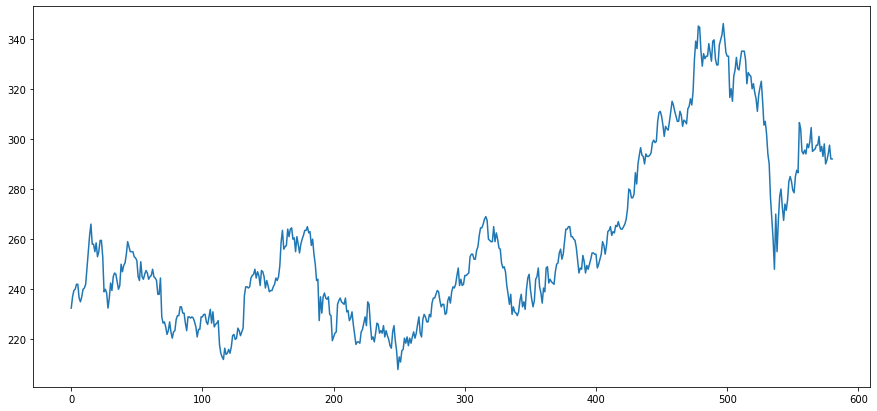

 取 80% data 當作 training data, 20% data 當作 testing data 做模型驗證 
 歸一化 
切 data，拿前五天的股價，預測未來1天的股價，先做個 demo
(458, 5) (458,) (52, 5) (52,)
轉換成 LSTM 建模所需 data 的型態
(458, 1, 5) (458,) (52, 1, 5) (52,)
設定參數
建立 DL 模型，使用 RNN 常見的 GRU and LSTM
_________________________________________________________________

C:\Users\kevin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '



Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 1, 256)            201216    
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 743,041
Trainable params: 743,041
Non-trainable params: 0
_________________________________________________________________
training
Train on 458 samples, validate on 52 samples
Epoch 1/5
458/4

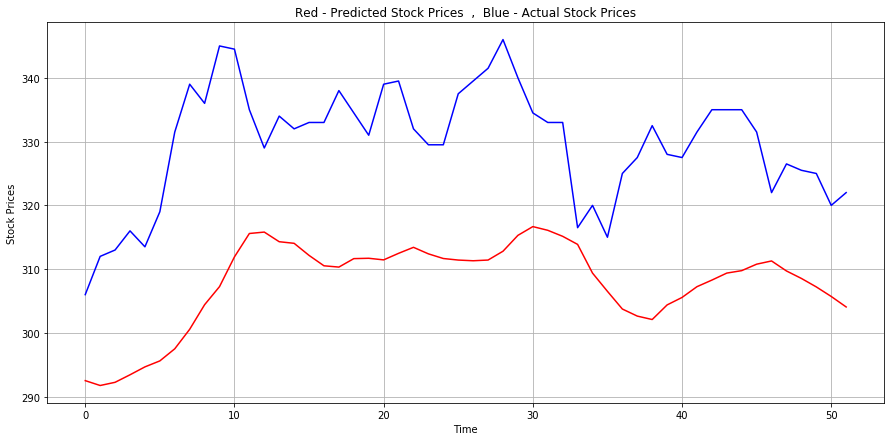

In [10]:
from FinMind.Data import Load
import numpy as np 
#import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras.layers.core import Dense, Dropout
from keras.layers import LSTM , GRU
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from keras.optimizers import Adam 

TaiwanStockInfo = Load.FinData(dataset = 'TaiwanStockInfo')

print('input data')
data = Load.FinData(
        dataset = 'TaiwanStockPrice',
        select = '2330',
        date = '2018-01-01')

#colname = ['date', 'open', 'high', 'low', 'close', 'volume']
#data = data[colname]
print('select close price')
date = [ str(d) for d in data['date'] ]
stock_price = data['close'].values.astype('float32')
stock_price = stock_price.reshape(len(stock_price), 1)

print(' 畫圖 ')
plt.plot(stock_price)
plt.show()

print(' 取 80% data 當作 training data, 20% data 當作 testing data 做模型驗證 ')
train_size = int(len(stock_price) * 0.8)
test_size = len(stock_price) - train_size
test_size = train_size + int(test_size/2)
valid_size = test_size

train = stock_price[:train_size,:]
test = stock_price[train_size:test_size,:]
valid = stock_price[valid_size:,:]

train_date = date[:train_size]
test_date = date[train_size:test_size]
valid_date = date[valid_size:]

print(' 歸一化 ')
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

print('切 data，拿前五天的股價，預測未來1天的股價，先做個 demo')
def process_data(data , n_features,future_days):
    dataX, dataY = [], []
    for i in range(len(data)-n_features-future_days):
        a = data[i:(i+n_features), 0]
        dataX.append(a)
        dataY.append(data[i + n_features-1+future_days, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+5
n_features = 5
future_days = 1

trainX, trainY = process_data(train, n_features,future_days)
testX, testY = process_data(test, n_features,future_days)
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

# lstm need input to have 3 dimensions
print('轉換成 LSTM 建模所需 data 的型態')
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape , trainY.shape , testX.shape , testY.shape)
'''  set up DL model '''
print('設定參數')
filepath="stock_weights.hdf5"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

print('建立 DL 模型，使用 RNN 常見的 GRU and LSTM')
model = Sequential()
model.add(GRU(256 , input_shape = (1 , n_features) , return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))
model.summary()

#model.load_weights('/home/linsam/job/stock_weight.h5')
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])
print('training')
history = model.fit(trainX, trainY, epochs=5 , batch_size = 128 , 
          callbacks = [checkpoint , lr_reduce] , validation_data = (testX,testY))
print(' save weight ')
model.save_weights('stock_weight.h5')


print('計算 error')
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

tem = model_score(model, trainX, trainY , testX, testY)


pred = model.predict(testX)
pred = scaler.inverse_transform(pred)
print('\n Actual Stock Prices')
print( pred[:10] )

testY2 = testY.reshape(testY.shape[0] , 1)
testY2 = scaler.inverse_transform(testY2)
print('\n Predicted Stock Prices ')
print( testY2[:10] )

print('畫圖')
print("\nRed - Predicted Stock Prices  ,  Blue - Actual Stock Prices")
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(testY2 , 'b')
plt.plot(pred , 'r')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices')
plt.grid(True)
plt.show()


In [9]:
trainX

array([[[0.03687739, 0.0349617 , 0.03687739, 0.0335249 , 0.03256705]],

       [[0.0349617 , 0.03687739, 0.0335249 , 0.03256705, 0.0349617 ]],

       [[0.03687739, 0.0335249 , 0.03256705, 0.0349617 , 0.03065133]],

       ...,

       [[0.8994252 , 0.9018199 , 0.913793  , 0.8994252 , 0.89703065]],

       [[0.9018199 , 0.913793  , 0.8994252 , 0.89703065, 0.8922413 ]],

       [[0.913793  , 0.8994252 , 0.89703065, 0.8922413 , 0.86590034]]],
      dtype=float32)